# Creating a Recommender Engine Pool and Genre Classification of Seed Tracks

In [2]:
!pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 6.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import joblib # joblib==1.2.0, install if needed

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import keyring
import time
import getpass
import ast

from tqdm import tqdm

In [4]:
# Mount GDrive folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set home directory
import os
home_dir = "drive/MyDrive/Eskwelabs/"
os.chdir(home_dir)

In [30]:
client_id = getpass.getpass(prompt='Enter Spotify app client id: ')

Enter Spotify app client id: ··········


In [31]:
client_secret = getpass.getpass(prompt='Enter Spotify app client secret: ')

Enter Spotify app client secret: ··········


In [32]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id,
                                                      client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Genre Classification of Seed Tracks

### 1. Read data

Read charts tracks data

In [33]:
charts = pd.read_csv('data/playlists/daily_charts/ph_spotify_daily_charts_10_23.csv')

In [34]:
# Filter SB19 songs
SB19_tracks = charts[charts['artist']=='SB19'].groupby(['track_id', 'track_name', 'artist'])['streams'].sum().reset_index()
SB19_tracks = SB19_tracks.sort_values(by='streams', ascending=False)
SB19_tracks = SB19_tracks
SB19_tracks

,track_id,track_name,artist,streams
18,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,SB19,28411613
6,1o6uF8VmXna99ysHTcQRI2,GENTO,SB19,14703248
4,0QQoU68nnBRWJqr9ak3mnS,MAPA (Band Version),SB19,7146034
14,5QZw4F3N3PvuKNKHm9L20b,Bazinga,SB19,2378357
7,1z50Hub2XCsAPWo8zgoePu,WYAT (Where You At),SB19,965975
5,16GGH8OF6LiSUTTbm8421f,I WANT YOU,SB19,832865
8,2WUhR1SraSy0SVIQKohJb6,Hanggang Sa Huli,SB19,624990
13,5Gm6YoDs8N2WznOpASSB5P,Go Up,SB19,533986
10,4sYZHEiueAYM5klpUbVNyk,What?,SB19,527582
9,3fNpKcMrEDrnjahY9kN5fQ,Alab (Burning),SB19,485997


In [35]:
seed_tracks_df = SB19_tracks[['track_id','track_name']].drop_duplicates(subset='track_id')
seed_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 18 to 3
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   track_id    21 non-null     object
 1   track_name  21 non-null     object
dtypes: object(2)
memory usage: 504.0+ bytes


In [36]:
# Helper function to get track data in table row format
# Caveat 1: If multiple artists are listed, this gets only the first artist

def get_track_data(track_id):
    # Get track data
    track_data = sp.track(track_id)
    # Populate dict
    relevant_track_data = {'track_id':track_id}
    relevant_track_data['track_name'] = track_data['name']
    relevant_track_data['artist_id'] = track_data['artists'][0]['id']
    relevant_track_data['artist_name'] = track_data['artists'][0]['name']
    relevant_track_data['album_id'] = track_data['album']['uri'].split(":")[2]
    relevant_track_data['duration'] = track_data['duration_ms']
    relevant_track_data['release_date'] = track_data['album']['release_date']
    relevant_track_data['popularity'] = track_data['popularity']

    # Get track audio features
    time.sleep(5)
    #track_audio_features_data = sp.audio_features(track_id)[0] # get first element
    audio_features_keys = ['danceability','energy','key','loudness','mode',\
                          'speechiness','acousticness','instrumentalness','liveness',\
                          'valence','tempo','duration_ms']
    #audio_features_keys = list(track_audio_features_data.keys())[:11]
    ### FIX: store API output as string and reparse to prevent automatic requery
    track_audio_features_data = str(sp.audio_features(track_id))
    track_audio_features_data_dict = ast.literal_eval(track_audio_features_data)[0]

    for key in audio_features_keys:
        try:
            relevant_track_data[key] = track_audio_features_data_dict[key]
        except:
            # If audio features are not available
            relevant_track_data[key] = None

    return relevant_track_data

In [37]:
track_ids = seed_tracks_df['track_id'].values[0:] # Comment out index to run for all tracks
downloaded_track_ids = []
all_track_data_list = []

In [38]:
progress_bar = tqdm(enumerate(track_ids), total=len(track_ids), position=0, mininterval=0, desc='Fetching track data ')
for i, track_id in progress_bar:
    if track_id in downloaded_track_ids:
        continue
    else:
        try:
            # If successful, save data to list add track id to downloaded_track_ids to track progress
            seed_track_data = get_track_data(track_id)
            downloaded_track_ids.append(track_id)
            all_track_data_list.append(seed_track_data)
            time.sleep(2)
        except Exception as e:
            # Print track id and error msg
            print(f'Error requesting data for track id {track_id}: {e}')
        # Sleep for 10 secs per 100 requests to avoid being blocked
        if (i % 100 == 0)&(i > 0):
            time.sleep(10)

Fetching track data : 100%|██████████| 21/21 [02:31<00:00,  7.20s/it]


In [39]:
seed_tracks_data_df = pd.DataFrame(all_track_data_list)
seed_tracks_data_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,64,0.561,0.651,9,-4.862,1,0.0689,0.3090,0.000000,0.3780,0.355,129.957,275420
1,1o6uF8VmXna99ysHTcQRI2,GENTO,3g7vYcdDXnqnDKYFwqXBJP,SB19,3cxdpO2eZx2VT2OWyca18o,232621,2023-05-19,72,0.799,0.701,1,-3.604,1,0.0826,0.0293,0.000033,0.1870,0.283,95.019,232622
2,0QQoU68nnBRWJqr9ak3mnS,MAPA (Band Version),3g7vYcdDXnqnDKYFwqXBJP,SB19,63OIQhMqDpmCRZO0d8Phfu,270411,2021-06-27,55,0.552,0.394,6,-10.784,0,0.0326,0.4190,0.000000,0.3870,0.487,126.915,270411
3,5QZw4F3N3PvuKNKHm9L20b,Bazinga,3g7vYcdDXnqnDKYFwqXBJP,SB19,4bieHSYaRSMRAoDF47qfSf,202506,2021-07-22,60,0.869,0.922,9,-1.452,1,0.0953,0.2060,0.000000,0.8310,0.388,115.034,202507
4,1z50Hub2XCsAPWo8zgoePu,WYAT (Where You At),3g7vYcdDXnqnDKYFwqXBJP,SB19,2KNLbEBtNGRbVGXH74zOcW,218461,2022-09-02,60,0.778,0.790,0,-5.179,0,0.0670,0.1850,0.000000,0.1270,0.783,116.986,218462
5,16GGH8OF6LiSUTTbm8421f,I WANT YOU,3g7vYcdDXnqnDKYFwqXBJP,SB19,7svCelXfTenSbzFXKj3zGF,223339,2023-06-09,66,0.674,0.681,1,-3.600,1,0.0464,0.2290,0.000000,0.0436,0.683,127.942,223340
6,2WUhR1SraSy0SVIQKohJb6,Hanggang Sa Huli,3g7vYcdDXnqnDKYFwqXBJP,SB19,4JlsfnNH8MCDXR0ypy1zcm,254469,2020-07-31,60,0.539,0.553,2,-4.338,1,0.0276,0.7020,0.000000,0.2050,0.192,132.045,254469
7,5Gm6YoDs8N2WznOpASSB5P,Go Up,3g7vYcdDXnqnDKYFwqXBJP,SB19,7cnW5rl7F9OkVxqbcJPNCq,189100,2019-07-19,0,0.704,0.944,0,-2.308,0,0.0420,0.4230,0.000000,0.1320,0.913,125.996,189100
8,4sYZHEiueAYM5klpUbVNyk,What?,3g7vYcdDXnqnDKYFwqXBJP,SB19,18g914rk7rcJP0o4uhz8uE,270192,2021-03-09,56,0.561,0.856,6,-3.710,0,0.1900,0.0575,0.000000,0.0728,0.507,95.975,270192
9,3fNpKcMrEDrnjahY9kN5fQ,Alab (Burning),3g7vYcdDXnqnDKYFwqXBJP,SB19,3twC225hfx6FrfrGAO3zvF,182750,2019-12-25,45,0.715,0.927,0,-2.120,1,0.0604,0.0176,0.000000,0.3400,0.792,119.974,182750


Remove tracks with no available/incomplete audio features

In [40]:
print(len(seed_tracks_data_df))
tracks_data_df = seed_tracks_data_df.dropna()
print(len(seed_tracks_data_df))

21
21


Remove duplicate tracks

In [41]:
print(len(seed_tracks_data_df))
seed_tracks_data_df = seed_tracks_data_df.drop_duplicates(subset=['artist_id','track_name'])
print(len(seed_tracks_data_df))

21
19


### 2. Load model pipeline

In [42]:
pipeline = joblib.load('data/playlists/genre_classifier_group4.pkl')
pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rfc', RandomForestClassifier(n_estimators=500))])

In [43]:
pipeline.named_steps['rfc']

RandomForestClassifier(n_estimators=500)

### 3. Predict track genres

Define features and genre id lookup dict

In [44]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

In [45]:
genre_lookup = {0: 'r&b', 1: 'electronic',2: 'jazz',
                3: 'rap',4: 'rock'}

Predict genre of each charting track using loaded pipeline

In [46]:
seed_tracks_data_df['predicted_genre_id'] = pipeline.predict(seed_tracks_data_df[feature_cols])
seed_tracks_data_df['predicted_genre'] = seed_tracks_data_df['predicted_genre_id'].map(genre_lookup)

<ipython-input-46-6481b8273656>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_tracks_data_df['predicted_genre_id'] = pipeline.predict(seed_tracks_data_df[feature_cols])
<ipython-input-46-6481b8273656>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_tracks_data_df['predicted_genre'] = seed_tracks_data_df['predicted_genre_id'].map(genre_lookup)


In [48]:
seed_tracks_data_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,predicted_genre_id,predicted_genre
0,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,64,0.561,0.651,...,1,0.0689,0.3090,0.000000,0.378,0.355,129.957,275420,2,jazz
1,1o6uF8VmXna99ysHTcQRI2,GENTO,3g7vYcdDXnqnDKYFwqXBJP,SB19,3cxdpO2eZx2VT2OWyca18o,232621,2023-05-19,72,0.799,0.701,...,1,0.0826,0.0293,0.000033,0.187,0.283,95.019,232622,3,rap
2,0QQoU68nnBRWJqr9ak3mnS,MAPA (Band Version),3g7vYcdDXnqnDKYFwqXBJP,SB19,63OIQhMqDpmCRZO0d8Phfu,270411,2021-06-27,55,0.552,0.394,...,0,0.0326,0.4190,0.000000,0.387,0.487,126.915,270411,4,rock
3,5QZw4F3N3PvuKNKHm9L20b,Bazinga,3g7vYcdDXnqnDKYFwqXBJP,SB19,4bieHSYaRSMRAoDF47qfSf,202506,2021-07-22,60,0.869,0.922,...,1,0.0953,0.2060,0.000000,0.831,0.388,115.034,202507,0,r&b
4,1z50Hub2XCsAPWo8zgoePu,WYAT (Where You At),3g7vYcdDXnqnDKYFwqXBJP,SB19,2KNLbEBtNGRbVGXH74zOcW,218461,2022-09-02,60,0.778,0.790,...,0,0.0670,0.1850,0.000000,0.127,0.783,116.986,218462,0,r&b


### 4. Create seed track pool with predicted genres and probabilities

In [49]:
seed_tracks_data_df['genre_probabilities']= pipeline.predict_proba(seed_tracks_data_df[feature_cols]).tolist()
seed_tracks_data_df['predicted_genre_proba'] = seed_tracks_data_df['genre_probabilities'].apply(lambda x: max(x))
seed_tracks_data_df.head()

<ipython-input-49-01e1a2d79fb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_tracks_data_df['genre_probabilities']= pipeline.predict_proba(seed_tracks_data_df[feature_cols]).tolist()
<ipython-input-49-01e1a2d79fb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_tracks_data_df['predicted_genre_proba'] = seed_tracks_data_df['genre_probabilities'].apply(lambda x: max(x))


,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,predicted_genre_id,predicted_genre,genre_probabilities,predicted_genre_proba
0,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,64,0.561,0.651,...,0.3090,0.000000,0.378,0.355,129.957,275420,2,jazz,"[0.298, 0.026, 0.438, 0.104, 0.134]",0.438
1,1o6uF8VmXna99ysHTcQRI2,GENTO,3g7vYcdDXnqnDKYFwqXBJP,SB19,3cxdpO2eZx2VT2OWyca18o,232621,2023-05-19,72,0.799,0.701,...,0.0293,0.000033,0.187,0.283,95.019,232622,3,rap,"[0.19, 0.018, 0.338, 0.426, 0.028]",0.426
2,0QQoU68nnBRWJqr9ak3mnS,MAPA (Band Version),3g7vYcdDXnqnDKYFwqXBJP,SB19,63OIQhMqDpmCRZO0d8Phfu,270411,2021-06-27,55,0.552,0.394,...,0.4190,0.000000,0.387,0.487,126.915,270411,4,rock,"[0.016, 0.254, 0.132, 0.066, 0.532]",0.532
3,5QZw4F3N3PvuKNKHm9L20b,Bazinga,3g7vYcdDXnqnDKYFwqXBJP,SB19,4bieHSYaRSMRAoDF47qfSf,202506,2021-07-22,60,0.869,0.922,...,0.2060,0.000000,0.831,0.388,115.034,202507,0,r&b,"[0.508, 0.028, 0.092, 0.272, 0.1]",0.508
4,1z50Hub2XCsAPWo8zgoePu,WYAT (Where You At),3g7vYcdDXnqnDKYFwqXBJP,SB19,2KNLbEBtNGRbVGXH74zOcW,218461,2022-09-02,60,0.778,0.790,...,0.1850,0.000000,0.127,0.783,116.986,218462,0,r&b,"[0.542, 0.0, 0.202, 0.166, 0.09]",0.542


In [50]:
genre_cols = [f'genre_{genre}_proba' for genre in genre_lookup.values()]
seed_tracks_data_df[genre_cols] = seed_tracks_data_df['genre_probabilities'].apply(pd.Series)
seed_tracks_data_df = seed_tracks_data_df.drop(columns=['genre_probabilities'])#drop column with probability list
seed_tracks_data_df

<ipython-input-50-2038ac1093d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_tracks_data_df[genre_cols] = seed_tracks_data_df['genre_probabilities'].apply(pd.Series)
<ipython-input-50-2038ac1093d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seed_tracks_data_df[genre_cols] = seed_tracks_data_df['genre_probabilities'].apply(pd.Series)
<ipython-input-50-2038ac1093d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,tempo,duration_ms,predicted_genre_id,predicted_genre,predicted_genre_proba,genre_r&b_proba,genre_electronic_proba,genre_jazz_proba,genre_rap_proba,genre_rock_proba
0,6Fz2TpxUD0YvAPsuG8nDMJ,MAPA,3g7vYcdDXnqnDKYFwqXBJP,SB19,4Qhx57hNp0CUmUbO2igtAq,275420,2021-05-16,64,0.561,0.651,...,129.957,275420,2,jazz,0.438,0.298,0.026,0.438,0.104,0.134
1,1o6uF8VmXna99ysHTcQRI2,GENTO,3g7vYcdDXnqnDKYFwqXBJP,SB19,3cxdpO2eZx2VT2OWyca18o,232621,2023-05-19,72,0.799,0.701,...,95.019,232622,3,rap,0.426,0.190,0.018,0.338,0.426,0.028
2,0QQoU68nnBRWJqr9ak3mnS,MAPA (Band Version),3g7vYcdDXnqnDKYFwqXBJP,SB19,63OIQhMqDpmCRZO0d8Phfu,270411,2021-06-27,55,0.552,0.394,...,126.915,270411,4,rock,0.532,0.016,0.254,0.132,0.066,0.532
3,5QZw4F3N3PvuKNKHm9L20b,Bazinga,3g7vYcdDXnqnDKYFwqXBJP,SB19,4bieHSYaRSMRAoDF47qfSf,202506,2021-07-22,60,0.869,0.922,...,115.034,202507,0,r&b,0.508,0.508,0.028,0.092,0.272,0.100
4,1z50Hub2XCsAPWo8zgoePu,WYAT (Where You At),3g7vYcdDXnqnDKYFwqXBJP,SB19,2KNLbEBtNGRbVGXH74zOcW,218461,2022-09-02,60,0.778,0.790,...,116.986,218462,0,r&b,0.542,0.542,0.000,0.202,0.166,0.090
5,16GGH8OF6LiSUTTbm8421f,I WANT YOU,3g7vYcdDXnqnDKYFwqXBJP,SB19,7svCelXfTenSbzFXKj3zGF,223339,2023-06-09,66,0.674,0.681,...,127.942,223340,2,jazz,0.276,0.262,0.048,0.276,0.166,0.248
6,2WUhR1SraSy0SVIQKohJb6,Hanggang Sa Huli,3g7vYcdDXnqnDKYFwqXBJP,SB19,4JlsfnNH8MCDXR0ypy1zcm,254469,2020-07-31,60,0.539,0.553,...,132.045,254469,4,rock,0.520,0.084,0.068,0.284,0.044,0.520
7,5Gm6YoDs8N2WznOpASSB5P,Go Up,3g7vYcdDXnqnDKYFwqXBJP,SB19,7cnW5rl7F9OkVxqbcJPNCq,189100,2019-07-19,0,0.704,0.944,...,125.996,189100,4,rock,0.692,0.200,0.006,0.054,0.048,0.692
8,4sYZHEiueAYM5klpUbVNyk,What?,3g7vYcdDXnqnDKYFwqXBJP,SB19,18g914rk7rcJP0o4uhz8uE,270192,2021-03-09,56,0.561,0.856,...,95.975,270192,2,jazz,0.320,0.106,0.034,0.320,0.306,0.234
9,3fNpKcMrEDrnjahY9kN5fQ,Alab (Burning),3g7vYcdDXnqnDKYFwqXBJP,SB19,3twC225hfx6FrfrGAO3zvF,182750,2019-12-25,45,0.715,0.927,...,119.974,182750,0,r&b,0.608,0.608,0.000,0.044,0.022,0.326


<Axes: >

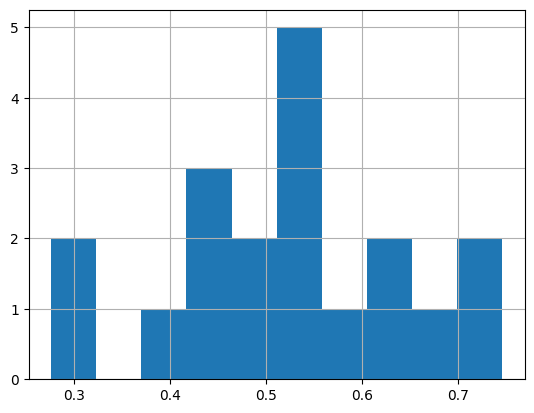

In [51]:
seed_tracks_data_df['predicted_genre_proba'].hist()

### 5. Save seed tracks data with genre

In [52]:
seed_tracks_data_df.to_csv("data/playlists/reco_pool/new_spotify_seed_tracks.csv", index=False, encoding='utf-8')

## Creating a Recommender Engine Pool using Top 200 Daily Charts

### 1. Read data

In [53]:
tracks = pd.read_csv('data/playlists/daily_charts/ph_spotify_daily_charts_tracks_10_23.csv')

In [54]:
tracks = tracks.drop(columns = ['duration_ms'])

In [55]:
print(len(tracks))
tracks = tracks.dropna()
print(len(tracks))

5001
4995


In [56]:
print(len(tracks))
tracks_data_df = tracks.drop_duplicates(subset=['artist_id','track_name'])
print(len(tracks))

4995
4995


In [57]:
tracks_data_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,75,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,87,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,71,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [58]:
tracks_data_df[tracks_data_df['artist_name']=='Justin Bieber']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
64,3hB5DgAiMAQ4DzYbsMq1IT,Love Yourself,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,7fZH0aUAjY3ay25obOUf2a,233720,2015-11-13,0,0.609,0.378,4.0,-9.828,1.0,0.4380,0.835000,0.000000,0.2800,0.5150,100.418
92,69bp2EbF7Q2rqc5N3ylezZ,Sorry,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,7fZH0aUAjY3ay25obOUf2a,200786,2015-11-13,0,0.654,0.760,0.0,-3.669,0.0,0.0450,0.079700,0.000000,0.2990,0.4100,99.945
163,3pzjHKrQSvXGHQ98dx18HI,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,7fZH0aUAjY3ay25obOUf2a,205680,2015-11-13,0,0.845,0.567,5.0,-8.118,0.0,0.0956,0.590000,0.001420,0.0811,0.7930,125.020
718,7nZmah2llfvLDiUjm0kiyz,Friends (with BloodPop®),1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6VABPTmDOYrO5cfyKZk7F7,189466,2017-08-17,0,0.744,0.739,8.0,-5.350,1.0,0.0387,0.004590,0.000000,0.3060,0.6490,104.990
971,32OWobmyAz8J2qA8iWekyS,Mistletoe,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,1wEnjjF0dtWufdTzWeQAm2,182946,2011-01-01,0,0.666,0.543,6.0,-9.188,0.0,0.0446,0.511000,0.000000,0.0911,0.8810,161.947
2472,41L3O37CECZt3N7ziG2z7l,Yummy,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,1SN6N3fNkZk5oXQ9X46QZ3,210426,2020-01-03,67,0.687,0.514,9.0,-6.612,0.0,0.0897,0.366000,0.000000,0.1160,0.4940,145.921
2517,6zGPytJiZmFuyVq7RTNO9G,Get Me,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,0GzsdiiItPCABfhuFIKiZi,185418,2020-01-28,50,0.824,0.503,6.0,-6.940,0.0,0.1560,0.050000,0.000053,0.1070,0.7840,109.397
2524,364dI1bYnvamSnBJ8JcNzN,Intentions,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,55zg331p7m1EFA4uRggkwt,212868,2020-02-07,72,0.811,0.553,9.0,-6.644,1.0,0.0552,0.317000,0.000000,0.1050,0.8600,148.014
2538,4umIPjkehX1r7uhmGvXiSV,Intentions (feat. Quavo),1uNFoZAHBGtllmzznpCI3s,Justin Bieber,63iWSELt9V1kV6RSMxN7Ii,212866,2020-02-14,76,0.806,0.546,9.0,-6.637,1.0,0.0575,0.300000,0.000000,0.1020,0.8740,147.986
2540,2ZlCGeK30BLRNSPC832pNZ,Forever (feat. Post Malone & Clever),1uNFoZAHBGtllmzznpCI3s,Justin Bieber,63iWSELt9V1kV6RSMxN7Ii,219933,2020-02-14,68,0.825,0.483,8.0,-5.746,0.0,0.0800,0.538000,0.000015,0.2040,0.8920,139.980


### 2. Predict track genres

In [59]:
tracks_data_df['predicted_genre_id'] = pipeline.predict(tracks_data_df[feature_cols])
tracks_data_df['predicted_genre'] = tracks_data_df['predicted_genre_id'].map(genre_lookup)

<ipython-input-59-c42bd3b26713>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_data_df['predicted_genre_id'] = pipeline.predict(tracks_data_df[feature_cols])
<ipython-input-59-c42bd3b26713>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_data_df['predicted_genre'] = tracks_data_df['predicted_genre_id'].map(genre_lookup)


In [60]:
tracks_data_df[tracks_data_df['artist_name']=='Justin Bieber']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre
64,3hB5DgAiMAQ4DzYbsMq1IT,Love Yourself,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,7fZH0aUAjY3ay25obOUf2a,233720,2015-11-13,0,0.609,0.378,...,-9.828,1.0,0.4380,0.835000,0.000000,0.2800,0.5150,100.418,3,rap
92,69bp2EbF7Q2rqc5N3ylezZ,Sorry,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,7fZH0aUAjY3ay25obOUf2a,200786,2015-11-13,0,0.654,0.760,...,-3.669,0.0,0.0450,0.079700,0.000000,0.2990,0.4100,99.945,0,r&b
163,3pzjHKrQSvXGHQ98dx18HI,What Do You Mean?,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,7fZH0aUAjY3ay25obOUf2a,205680,2015-11-13,0,0.845,0.567,...,-8.118,0.0,0.0956,0.590000,0.001420,0.0811,0.7930,125.020,2,jazz
718,7nZmah2llfvLDiUjm0kiyz,Friends (with BloodPop®),1uNFoZAHBGtllmzznpCI3s,Justin Bieber,6VABPTmDOYrO5cfyKZk7F7,189466,2017-08-17,0,0.744,0.739,...,-5.350,1.0,0.0387,0.004590,0.000000,0.3060,0.6490,104.990,2,jazz
971,32OWobmyAz8J2qA8iWekyS,Mistletoe,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,1wEnjjF0dtWufdTzWeQAm2,182946,2011-01-01,0,0.666,0.543,...,-9.188,0.0,0.0446,0.511000,0.000000,0.0911,0.8810,161.947,3,rap
2472,41L3O37CECZt3N7ziG2z7l,Yummy,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,1SN6N3fNkZk5oXQ9X46QZ3,210426,2020-01-03,67,0.687,0.514,...,-6.612,0.0,0.0897,0.366000,0.000000,0.1160,0.4940,145.921,3,rap
2517,6zGPytJiZmFuyVq7RTNO9G,Get Me,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,0GzsdiiItPCABfhuFIKiZi,185418,2020-01-28,50,0.824,0.503,...,-6.940,0.0,0.1560,0.050000,0.000053,0.1070,0.7840,109.397,2,jazz
2524,364dI1bYnvamSnBJ8JcNzN,Intentions,1uNFoZAHBGtllmzznpCI3s,Justin Bieber,55zg331p7m1EFA4uRggkwt,212868,2020-02-07,72,0.811,0.553,...,-6.644,1.0,0.0552,0.317000,0.000000,0.1050,0.8600,148.014,3,rap
2538,4umIPjkehX1r7uhmGvXiSV,Intentions (feat. Quavo),1uNFoZAHBGtllmzznpCI3s,Justin Bieber,63iWSELt9V1kV6RSMxN7Ii,212866,2020-02-14,76,0.806,0.546,...,-6.637,1.0,0.0575,0.300000,0.000000,0.1020,0.8740,147.986,3,rap
2540,2ZlCGeK30BLRNSPC832pNZ,Forever (feat. Post Malone & Clever),1uNFoZAHBGtllmzznpCI3s,Justin Bieber,63iWSELt9V1kV6RSMxN7Ii,219933,2020-02-14,68,0.825,0.483,...,-5.746,0.0,0.0800,0.538000,0.000015,0.2040,0.8920,139.980,3,rap


### 3. Create recommender engine pool with predicted genres and probabilities

In [61]:
tracks_data_df['genre_probabilities']= pipeline.predict_proba(tracks_data_df[feature_cols]).tolist()
tracks_data_df['predicted_genre_proba'] = tracks_data_df['genre_probabilities'].apply(lambda x: max(x))
tracks_data_df.head()

<ipython-input-61-c17f1b2b20bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_data_df['genre_probabilities']= pipeline.predict_proba(tracks_data_df[feature_cols]).tolist()
<ipython-input-61-c17f1b2b20bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_data_df['predicted_genre_proba'] = tracks_data_df['genre_probabilities'].apply(lambda x: max(x))


,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_genre_id,predicted_genre,genre_probabilities,predicted_genre_proba
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,75,0.578,0.574,...,0.0454,0.196,0.00000,0.0830,0.301,174.152,2,jazz,"[0.17, 0.036, 0.346, 0.276, 0.172]",0.346
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,87,0.358,0.557,...,0.0590,0.695,0.00000,0.0902,0.494,85.043,1,electronic,"[0.028, 0.328, 0.308, 0.202, 0.134]",0.328
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,...,0.0338,0.414,0.00000,0.1110,0.661,95.010,2,jazz,"[0.026, 0.002, 0.702, 0.122, 0.148]",0.702
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,71,0.662,0.586,...,0.0307,0.097,0.00272,0.1150,0.296,90.000,4,rock,"[0.084, 0.054, 0.24, 0.162, 0.46]",0.460
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,...,0.0800,0.338,0.00000,0.0975,0.447,100.048,3,rap,"[0.282, 0.014, 0.198, 0.498, 0.008]",0.498


In [62]:
genre_cols = [f'genre_{genre}_proba' for genre in genre_lookup.values()]
tracks_data_df[genre_cols] = tracks_data_df['genre_probabilities'].apply(pd.Series)
tracks_data_df = tracks_data_df.drop(columns=['genre_probabilities'])#drop column with probability list
tracks_data_df

<ipython-input-62-bbdc3819f0d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_data_df[genre_cols] = tracks_data_df['genre_probabilities'].apply(pd.Series)
<ipython-input-62-bbdc3819f0d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_data_df[genre_cols] = tracks_data_df['genre_probabilities'].apply(pd.Series)
<ipython-input-62-bbdc3819f0d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_proba,genre_r&b_proba,genre_electronic_proba,genre_jazz_proba,genre_rap_proba,genre_rock_proba
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,75,0.578,0.574,...,0.301,174.152,2,jazz,0.346,0.170,0.036,0.346,0.276,0.172
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,87,0.358,0.557,...,0.494,85.043,1,electronic,0.328,0.028,0.328,0.308,0.202,0.134
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,...,0.661,95.010,2,jazz,0.702,0.026,0.002,0.702,0.122,0.148
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,71,0.662,0.586,...,0.296,90.000,4,rock,0.460,0.084,0.054,0.240,0.162,0.460
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,...,0.447,100.048,3,rap,0.498,0.282,0.014,0.198,0.498,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,1qzvzPfqzpNQ01ZBOEkVlf,Yawn,7nqOGRxlXj7N2JYbgNEjYH,SEVENTEEN,1rE0Gy69MFUh4GuXafWd0f,258213,2023-10-23,0,0.443,0.426,...,0.402,171.907,4,rock,0.640,0.022,0.186,0.124,0.028,0.640
4997,6n5M2Al3QgTScpO4AZH9OI,Diamond Days,7nqOGRxlXj7N2JYbgNEjYH,SEVENTEEN,1rE0Gy69MFUh4GuXafWd0f,205866,2023-10-23,0,0.811,0.804,...,0.695,115.031,0,r&b,0.506,0.506,0.000,0.198,0.236,0.060
4998,1fRLcqxVwpzpua8E6Se2sN,MY THANG (GO GETTA 2),4O19i2jHEjPyz17BeiwbDp,O SIDE MAFIA,2iLm8scmBP9VcNixtMIf4G,190660,2023-10-20,55,0.975,0.693,...,0.939,107.002,2,jazz,0.498,0.094,0.020,0.498,0.276,0.112
4999,6Es0Sxn1yE7L0T1YxrYHKX,Headliner,7nqOGRxlXj7N2JYbgNEjYH,SEVENTEEN,1rE0Gy69MFUh4GuXafWd0f,189813,2023-10-23,0,0.483,0.723,...,0.372,175.976,4,rock,0.538,0.290,0.022,0.124,0.026,0.538


<Axes: >

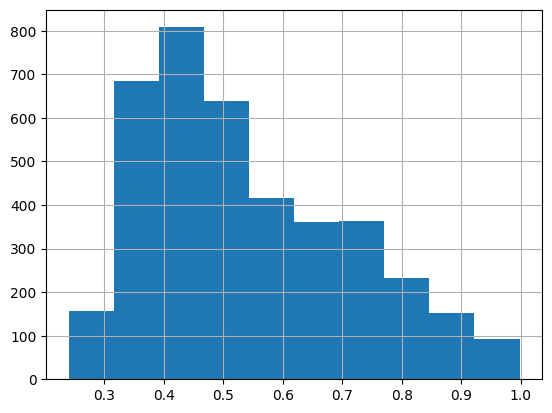

In [63]:
tracks_data_df['predicted_genre_proba'].hist()

### 4. Save top 200 daily charts tracks with genre

In [64]:
tracks_data_df.to_csv("data/playlists/reco_pool/new_top_200_tracks.csv", index=False, encoding='utf-8')